# VirFinder Analysis

In [1]:
%matplotlib inline

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import classification_report,roc_auc_score,accuracy_score,roc_curve, auc

In [4]:

def load_data(files):
    df = pd.DataFrame()
    list_ = []
    for file in files:
        file_path=os.path.join(data_dir,file)
        frame = pd.read_csv(file_path)
        if 'non_viral' in file:
            frame['ytest']=0
            frame['score'].fillna(1, inplace=True)
        else:
            frame['ytest']=1
            frame['score'].fillna(0, inplace=True)
        list_.append(frame)
    df = pd.concat(list_)
    return df['score'].values,df['ytest'].values

def label_fragment(st):
    if('reference=V_' in st):
        return 1
    else:
        return 0
        
def load_genome_data(files):
    frame = pd.read_csv(file_path)
    frame['ytest']=frame['name'].apply(label_fragment)
    frame['score'].fillna(1, inplace=True)
    return frame['score'].values,frame['ytest'].values


def roc_curve_plot(y_score,y_test):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test, y_score)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.figure()
    plt.plot(fpr['micro'], tpr['micro'], color='darkorange',
             lw=2, label='AUC curve (area = %0.2f)' % roc_auc['micro'])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

def evaluation(y_score,y_test):
    y_pred=(y_score > 0.5).astype(int)
    result=[]
    result.append('Accuracy:\t{0:.2f}%'.format(accuracy_score(y_test, y_pred)*100))
    result.append('ROC-AUC Score:\t{0:.2f}'.format(roc_auc_score(y_test, y_pred)))
    result.append('Classification Report:\n{0}'.format(classification_report(y_test, y_pred)))
    return result

##  1. VirFinder

### Fragment Analysis

In [8]:
data_dir='../../benchmark/results'
output_dir='../../benchmark/analysis'

fragments=dict()
for file in os.listdir(data_dir):
    n=int(file.split('_')[-1].split('.')[0])
    if n in fragments:
        fragments[n].append(file)
    else:
        fragments[n]=[file]

        
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

output_log=[]
for n in sorted(fragments):
    output_log.append("#"*50)
    output_log.append("Evaluating {0} bp".format(n))
    files=fragments[n]
    y_score,y_test=load_data(files)
    result=evaluation(y_score,y_test)
    output_log.extend(result)
    #roc_curve_plot(y_score,y_test)
    fpr[n], tpr[n], _ = roc_curve(y_test, y_score)
    roc_auc[n] = auc(fpr[n], tpr[n])
print('\n'.join(output_log))
with open(os.path.join(output_dir,'analysis.txt'),'w+') as f:
    f.write('\n'.join(output_log))

##################################################
Evaluating 100 bp
Accuracy:	63.90%
ROC-AUC Score:	0.64
Classification Report:
             precision    recall  f1-score   support

          0       0.63      0.65      0.64    517673
          1       0.65      0.63      0.64    527020

avg / total       0.64      0.64      0.64   1044693

##################################################
Evaluating 500 bp
Accuracy:	75.61%
ROC-AUC Score:	0.75
Classification Report:
             precision    recall  f1-score   support

          0       0.82      0.78      0.80    174566
          1       0.66      0.72      0.69    106168

avg / total       0.76      0.76      0.76    280734

##################################################
Evaluating 1000 bp
Accuracy:	80.28%
ROC-AUC Score:	0.78
Classification Report:
             precision    recall  f1-score   support

          0       0.89      0.83      0.86    139822
          1       0.62      0.74      0.67     53528

avg / total       0.8

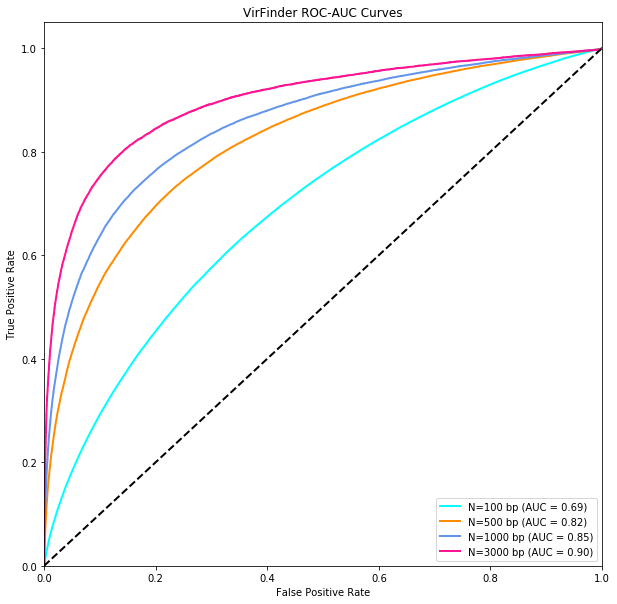

In [9]:
# Plot all ROC curves
plt.figure(figsize=(10, 10))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','deeppink'])
for n, color in zip(sorted(fragments), colors):
    plt.plot(fpr[n], tpr[n], color=color, lw=2,
             label='N={0} bp (AUC = {1:0.2f})'.format(n, roc_auc[n]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VirFinder ROC-AUC Curves')
plt.legend(loc="lower right")

plt.savefig(os.path.join(output_dir,'roc_auc.png'))

### Metagenome Analysis

In [10]:
data_dir='../../benchmark/sim_results'
output_dir='../../benchmark/analysis'

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

output_log=[]
for file in os.listdir(data_dir):
    output_log.append("#"*50)
    output_log.append("Evaluating {0} ".format(file))
    file_path=os.path.join(data_dir,file)
    y_score,y_test=load_genome_data(file_path)
    result=evaluation(y_score,y_test)
    output_log.extend(result)
    #roc_curve_plot(y_score,y_test)
    fpr[file], tpr[file], _ = roc_curve(y_test, y_score)
    roc_auc[file] = auc(fpr[file], tpr[file])
print('\n'.join(output_log))

with open(os.path.join(output_dir,'analysis_simulated.txt'),'w+') as f:
    f.write('\n'.join(output_log))

##################################################
Evaluating microbiome-reads.fa.csv 
Accuracy:	64.49%
ROC-AUC Score:	0.64
Classification Report:
             precision    recall  f1-score   support

          0       0.84      0.65      0.73    745345
          1       0.38      0.64      0.48    254655

avg / total       0.72      0.64      0.67   1000000

##################################################
Evaluating virome-reads.fa.csv 
Accuracy:	62.77%
ROC-AUC Score:	0.63
Classification Report:
             precision    recall  f1-score   support

          0       0.36      0.64      0.46    247996
          1       0.84      0.62      0.72    752004

avg / total       0.72      0.63      0.65   1000000



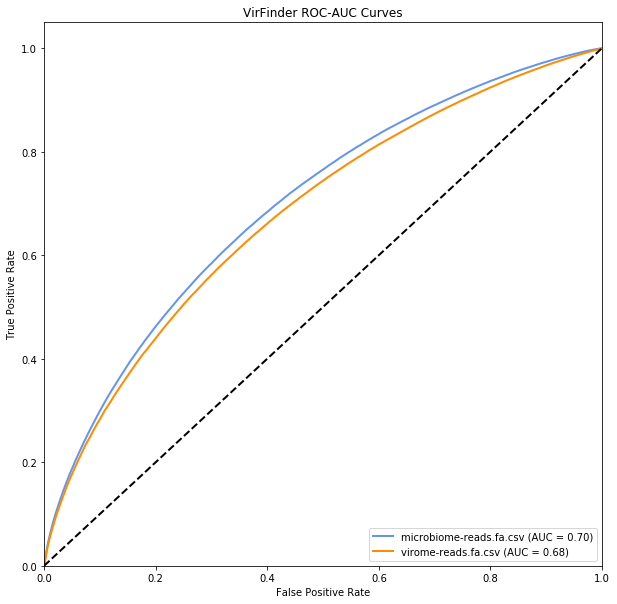

In [11]:
# Plot all ROC curves
plt.figure(figsize=(10, 10))

colors = cycle(['cornflowerblue', 'darkorange'])
for file, color in zip(sorted(os.listdir(data_dir)), colors):
    plt.plot(fpr[file], tpr[file], color=color, lw=2,
             label='{0} (AUC = {1:0.2f})'.format(file, roc_auc[file]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VirFinder ROC-AUC Curves')
plt.legend(loc="lower right")

plt.savefig(os.path.join(output_dir,'roc_auc_simulated.png'))

## VirNet